# SIR modelling
## load libraries

In [47]:
import numpy as np
from datetime import datetime
import pandas as pd 
from scipy import optimize, integrate

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="darkgrid")
mpl.rcParams['figure.figsize'] = (16, 9)

## load data

- Interested in USA data specifically 
- load USA data as our observation

In [48]:
df_global=pd.read_csv('datasets/sub_global.csv',sep='\t')  
df_global.sort_values('date',ascending=True).head()
ydata = np.array(df_global.US[30:])
t=np.arange(len(ydata))

## SIR model setting up
  - 1. Initial values of populations and initial guess of parameters
  - 2. SIR model

In [49]:
N0=1000000 #max susceptible population, fixed values
beta=0.4   # infection rate
gamma=0.1  # recovery rate

# initial populations I0+S0+R0=N0
I0=df_global.US[30]
S0=N0-I0
R0=0

# SIR model v1
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected population
        R: recovered population
        S+I+R= N (fix limited poplation siz)
        params: beta infection rate
        params: gamma recovery rate
    '''
    
    S,I,R=SIR
    dSdt= -beta*S*I/N0 
    dIdt= beta*S*I/N0-gamma*I
    dRdt= gamma*I
    return([dSdt,dIdt,dRdt])

# SIR model v2, same setting as v1
# SIR_t only for optimization 
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected population
        R: recovered population
        S+I+R= N (fix limited poplation siz)
        params: beta infection rate
        params: gamma recovery rate
    '''
    S,I,R=SIR
    dSdt=-beta*S*I/N0
    dIdt=beta*S*I/N0-gamma*I
    dRdt=gamma*I
    return dSdt,dIdt,dRdt

# helper function to calculate SIR
def SIR_solver(x, beta, gamma):
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] 


## Parameter Optimization 

  - result: infected rate is around 0.19
  - result: recovery rate is around 0, this may indicate that we are still in the spreading phase

In [50]:
"""
optimize.curve_fit
return: popt optimal values for the parameters
return: The estimated covariance of popt.
To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov))
"""
popt, pcov = optimize.curve_fit(SIR_solver, t, ydata)
perr = np.sqrt(np.diag(pcov))

print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

/Users/yiruichen/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/yiruichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars
/Users/yiruichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in double_scalars
/Users/yiruichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in double_scalars


standard deviation errors :  [0.00227917 0.00118006]  start infect: 15
Optimal parameters: beta = 0.2287003104413908  and gamma =  0.0027451188570540106


In [51]:
fitted=SIR_solver(t, *popt)

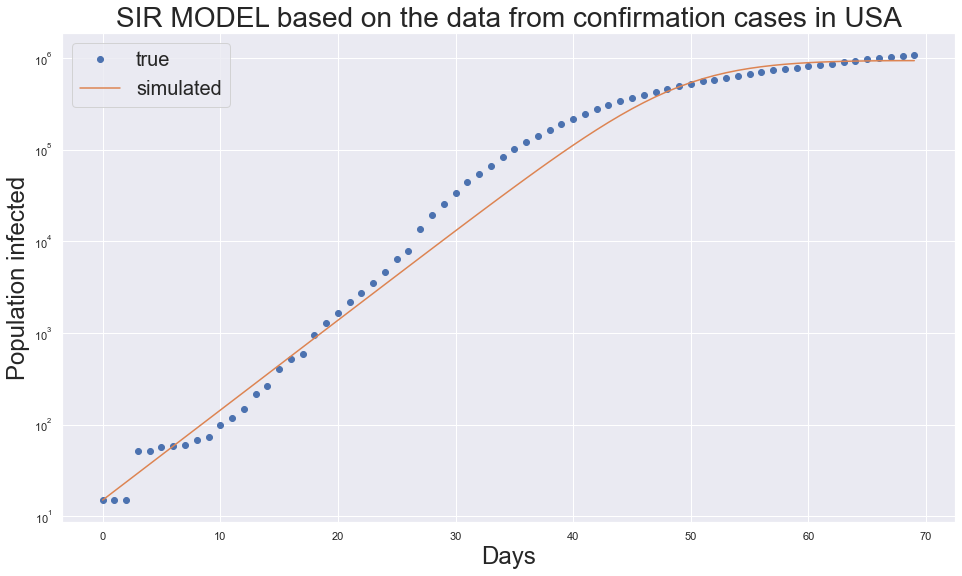

Optimal parameters: beta = 0.23  and gamma =  0.0


In [52]:
plt.semilogy(t, ydata, 'o', label = 'true')
plt.semilogy(t, fitted, label ='simulated')
plt.title("SIR MODEL based on the data from confirmation cases in USA", fontsize=28)
plt.ylabel("Population infected", fontsize=24)
plt.xlabel("Days", fontsize=24)
plt.legend(fontsize=20)
plt.show()
print("Optimal parameters: beta =", round(popt[0],2), " and gamma = ", round(popt[1],2))

## Try Parameter sweeping

In [53]:
t_initial=28
t_intro_measures=28
t_rebound= 30
t_hold=5

beta_max=0.3
beta_min=0.1
beta_rebound= 0.5
# beta_max2 = 1
gamma=0.01
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                        np.linspace(beta_max,beta_min,t_intro_measures),
                        np.array(t_hold*[beta_min]),
                        np.array(t_rebound*[beta_rebound]),
                       ))

In [54]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

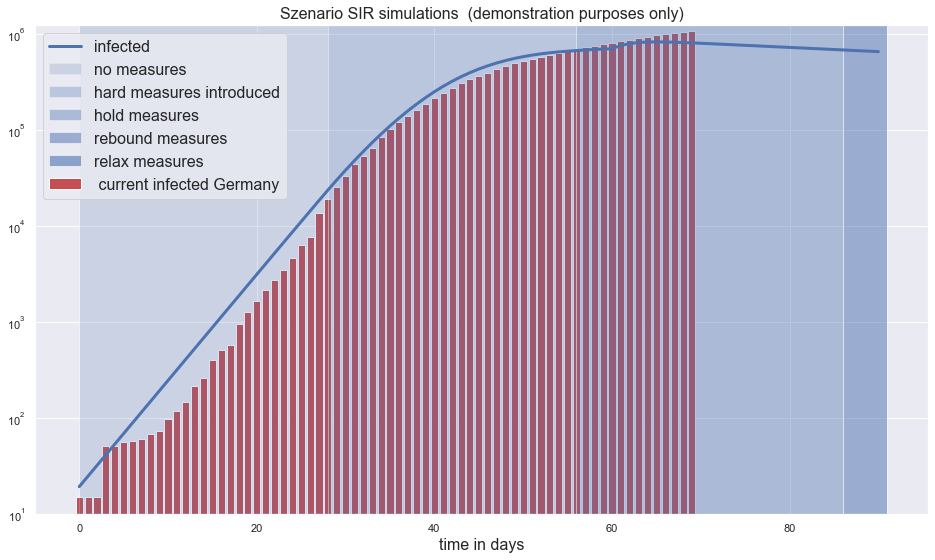

In [55]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_rebound,t_hold]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='rebound measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='relax measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});